In [19]:
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
os.getcwd()

'/Users/cd8607/Documents/Test_Potentials'

In [21]:
if os.getcwd() == '/Users/cd8607/Documents/Test_Potentials':
    pass
else:
    os.chdir('../')

In [22]:
def create_entry(data, defect_key, val_type , val, ref):

    if defect_key not in data.keys():
        data[defect_key] = {}
        data[defect_key]['eam'] = {}
        data[defect_key]['eam']['val'] = []
        data[defect_key]['eam']['ref'] = []

        data[defect_key]['dft'] = {}
        data[defect_key]['dft']['val'] = []
        data[defect_key]['dft']['ref'] = []

        data[defect_key]['new'] = {}
        data[defect_key]['new']['val'] = []
        data[defect_key]['new']['ref'] = []

        data[defect_key]['r_vol_dft'] = {}
        data[defect_key]['r_vol_dft']['val'] = []
        data[defect_key]['r_vol_dft']['ref'] = []

        data[defect_key]['r_vol_new'] = {}
        data[defect_key]['r_vol_new']['val'] = []
        data[defect_key]['r_vol_new']['ref'] = []

    if val_type not in data[defect_key].keys():
        
        data[defect_key][val_type] = {}
        data[defect_key][val_type]['val'] = []
        data[defect_key][val_type]['ref'] = []
    
    data[defect_key][val_type]['val'].append(val)
    data[defect_key][val_type]['ref'].append(ref)

    return data

In [23]:
with open('Data/References/refs_formations.json','r') as file:
    ref_formation = json.load(file)

with open('Data/References/refs_bonding.json','r') as file:
    ref_bonding = json.load(file)

with open('Data/My Data/point_defects_formations.json', 'r') as file:
    my_formation = json.load(file)

with open('Data/My Data/my_bonding.json', 'r') as file:
    my_bonding = json.load(file)

with open('Data/References/refs.json', 'r') as file:
    refs = json.load(file)

In [24]:
compiled_formation = ref_formation

for key in my_formation:
    compiled_formation = create_entry(compiled_formation, key, 'new', my_formation[key]['energy_opt'], -1)
    compiled_formation = create_entry(compiled_formation, key, 'r_vol_new', my_formation[key]['relaxation_volume'], -1)

In [25]:
df = pd.DataFrame(compiled_formation)

print(df['V0H0He1'])

eam                         {'val': [6.69], 'ref': [0]}
dft                         {'val': [6.16], 'ref': [3]}
new          {'val': [6.2083153789944845], 'ref': [-1]}
r_vol_dft        {'val': [0.36, 0.33], 'ref': [11, 12]}
r_vol_new    {'val': [0.3742167498818002], 'ref': [-1]}
Name: V0H0He1, dtype: object


In [26]:
def lookup_ref(lookup_table, find_val):
    for key, val in lookup_table.items():
        if val == find_val:
            return key

In [27]:
tex_table = '''\\begin{tabular}{lrrrrrrr} \n
               \\toprule \n
               Defect Type & DFT /eV & EAM /eV & My EAM /eV & $\Omega_{\\text{DFT}} /a^3$ & $\Omega_{\\text{new}} /a^3$ \\\ \n'''
for key in df:

    tex_table += '\\ce{%s}' % key

    tex_table += ' & '

    #DFT /eV
    for i, val in enumerate(df[key]['dft']['val']):
        tex_table += '%.2f \cite{%s} ' % (val, lookup_ref(refs['lookup'], df[key]['dft']['ref'][i]) ) 
    
    tex_table += ' & '

    #EAM /eV
    for i, val in enumerate(df[key]['eam']['val']):
        tex_table += '%.2f \cite{%s} ' % (val, lookup_ref(refs['lookup'], df[key]['eam']['ref'][i]) )
    
    tex_table += ' & '

    #New /eV
    for i, val in enumerate(df[key]['new']['val']):
        tex_table += '%.2f' % (val)
     
    tex_table += ' & '

    #Relax_Volume_DFT /eV
    for i, val in enumerate(df[key]['r_vol_dft']['val']):
        tex_table += '%.2f \cite{%s} ' % (val, lookup_ref(refs['lookup'], df[key]['r_vol_dft']['ref'][i]) )
     
    tex_table += ' & '

    #Relax_Volume_New /eV
    for i, val in enumerate(df[key]['r_vol_new']['val']):
        tex_table += '%.2f ' % (val)
     
    tex_table += ' \\\ \n'

tex_table += '\\end{tabular}'

In [28]:
with open('Data/My Data/Formations_Table.tex', 'w') as file:
    file.write(tex_table)

In [29]:
bib_tex = ''

for key in refs:
    if key != 'lookup':
        bib_tex += refs[key]
        bib_tex += '\n'

with open('Data/My Data/references.bib', 'w') as file:
    file.write(bib_tex)

In [30]:
def mean_lst(lst):
    
    if len(lst) > 0:
        return sum(lst)/len(lst)
    else:
        return 0

def df_to_lst(df, defect, trend_element, val_type):
    
    defect = np.array(defect)

    trend_element = np.array(trend_element)

    key = 'V%dH%dHe%d' % (defect[0],defect[1], defect[2])

    lst = []

    while key in df.columns:
        
        if len(df[key][val_type]['val']) == 0:
            break
        
        lst.append(mean_lst(df[key][val_type]['val']))
        
        defect += trend_element

        key = 'V%dH%dHe%d' % (defect[0],defect[1], defect[2])
        
    return lst 


def find_binding(df, defect, add_element, trend_element, val_type):

    add_int = mean_lst(df['V%dH%dHe%d' % (add_element[0], add_element[1], add_element[2])][val_type]['val'])
    
    defect = np.array(defect)

    add_element = np.array(add_element)

    trend_element = np.array(trend_element)

    defect_next = defect + add_element

    key_curr = 'V%dH%dHe%d' % (defect[0],defect[1], defect[2])

    key_next = 'V%dH%dHe%d' % (defect_next[0],defect_next[1], defect_next[2])

    init_config = []
    final_config = []

    while key_next in df.columns:
        
        if len(df[key_next][val_type]['val']) == 0:
            break
        
        init_config.append(mean_lst(df[key_curr][val_type]['val']))
        
        final_config.append(mean_lst(df[key_next][val_type]['val']))

        defect += trend_element

        defect_next += trend_element

        key_curr = 'V%dH%dHe%d' % (defect[0],defect[1], defect[2])
        
        key_next = 'V%dH%dHe%d' % (defect_next[0],defect_next[1], defect_next[2])

    init_config = np.array(init_config)

    final_config = np.array(final_config)
    
    return add_int + init_config - final_config

def create_plt(axes, idx, eam, dft, new, title, xlabel, ylabel):
    axes[idx].set_title(title)
    axes[idx].set_xlabel(xlabel)
    axes[idx].set_ylabel(ylabel)
    axes[idx].plot(np.arange(1,len(new) + 1), new, marker = 'o')
    axes[idx].plot(np.arange(1,len(dft) + 1), dft, marker ='o')
    axes[idx].plot(np.arange(1,len(eam) + 1), eam, marker = 'o')
    axes[idx].set_xticks(np.arange(1,len(new) + 1))
    axes[idx].legend(['new', 'dft', 'eam'])
    return axes

[4.58537667 2.67194316 2.54597405 2.39997179 1.96634319 2.63215158] [4.625 3.135 3.235 3.225 2.045 2.225 2.56  2.09 ]
[4.81225708 4.62667712 4.03988101 2.82061015 2.88375103 2.71160115] [4.69 4.85 3.97]


Text(0.5, 0.98, 'Sequential Trapping of Helium into Vacancy-Helium clusters: $V_yH_0He_x + He$\u200b')

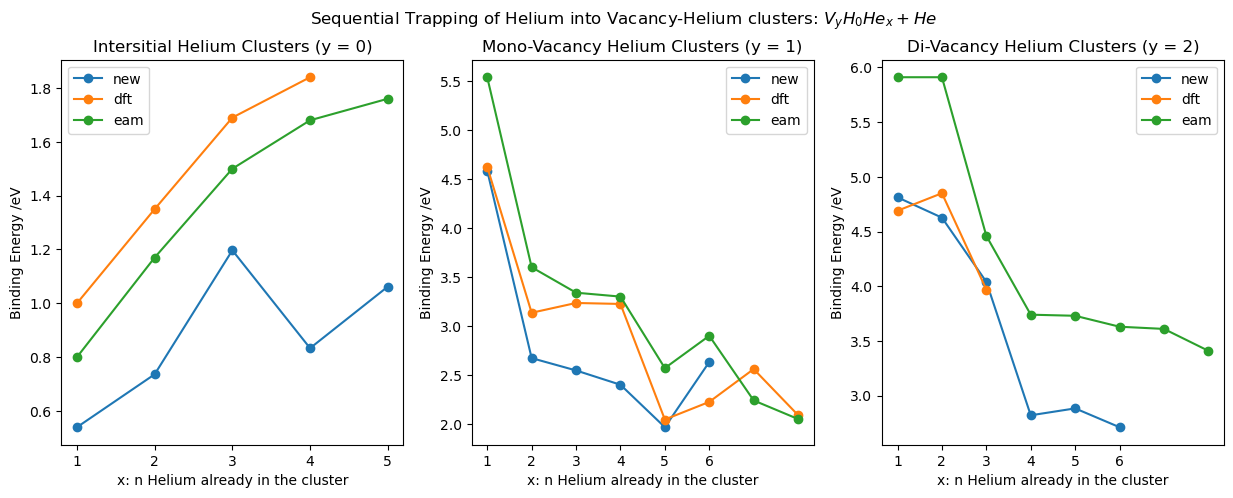

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

xlabel = 'x: n Helium already in the cluster'
ylabel = 'Binding Energy /eV'

### Sequential Trapping of Helium into Intersitial Helium Clusters ###
eam = find_binding(df, [0,0,1], [0,0,1], [0,0,1], 'eam')
dft = find_binding(df, [0,0,1], [0,0,1], [0,0,1], 'dft')
new = find_binding(df, [0,0,1], [0,0,1], [0,0,1], 'new')


title = 'Intersitial Helium Clusters (y = 0)'
axes = create_plt(axes, 0, eam, dft, new, title, xlabel, ylabel)

### Sequential Trapping of Helium into a Mono-Vacancy Helium Clusters ###
eam = find_binding(df, [1,0,0], [0,0,1], [0,0,1], 'eam')
dft = find_binding(df, [1,0,0], [0,0,1], [0,0,1], 'dft')
new = find_binding(df, [1,0,0], [0,0,1], [0,0,1], 'new')
print(new, dft)

title = 'Mono-Vacancy Helium Clusters (y = 1)'
axes = create_plt(axes, 1, eam, dft, new, title, xlabel, ylabel)


### Sequential Trapping of Helium into Di-Vacancy Helium Clusters ###
eam = find_binding(df, [2,0,0], [0,0,1], [0,0,1], 'eam')
dft = find_binding(df, [2,0,0], [0,0,1], [0,0,1], 'dft')
new = find_binding(df, [2,0,0], [0,0,1], [0,0,1], 'new')

print(new, dft)

title = 'Di-Vacancy Helium Clusters (y = 2)' 
axes = create_plt(axes, 2, eam, dft, new, title, xlabel, ylabel)

fig.suptitle(r'Sequential Trapping of Helium into Vacancy-Helium clusters: $V_yH_0He_x + He$​')

Text(0.5, 0.98, 'Sequential Trapping of Hydrogen into Intersitial Helium-Hydrogen clusters: $V_0H_yHe_x + H$')

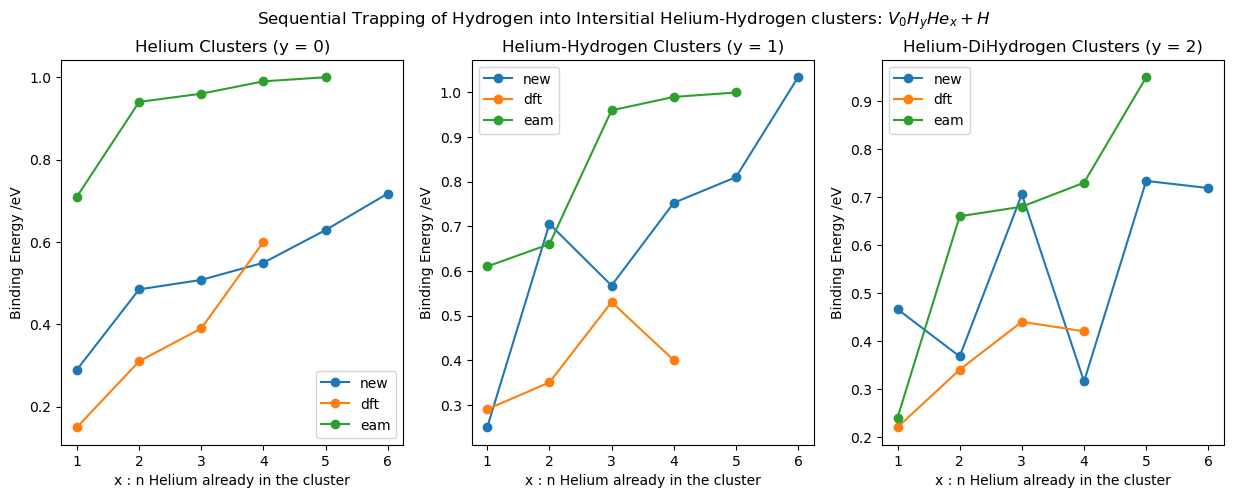

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

xlabel = 'x : n Helium already in the cluster'
ylabel = 'Binding Energy /eV'

### Sequential Trapping of Hydrogen into Intersitial Helium Clusters ###
eam = find_binding(df, [0,0,1], [0,1,0], [0,0,1], 'eam')
dft = find_binding(df, [0,0,1], [0,1,0], [0,0,1], 'dft')
new = find_binding(df, [0,0,1], [0,1,0], [0,0,1], 'new')

title = 'Helium Clusters (y = 0)'
axes = create_plt(axes, 0, eam, dft, new, title, xlabel, ylabel)

### Sequential Trapping of Hydrogen into a Intersitial Helium-Hydrogen Clusters ###
eam = find_binding(df, [0,1,1], [0,1,0], [0,0,1], 'eam')
dft = find_binding(df, [0,1,1], [0,1,0], [0,0,1], 'dft')
new = find_binding(df, [0,1,1], [0,1,0], [0,0,1], 'new')

title = 'Helium-Hydrogen Clusters (y = 1)'
axes = create_plt(axes, 1, eam, dft, new, title, xlabel, ylabel)


### Sequential Trapping of Hydrogen into Intersitial Helium-DiHydrogen Clusters ###
eam = find_binding(df, [0,2,1], [0,1,0], [0,0,1], 'eam')
dft = find_binding(df, [0,2,1], [0,1,0], [0,0,1], 'dft')
new = find_binding(df, [0,2,1], [0,1,0], [0,0,1], 'new')

title = 'Helium-DiHydrogen Clusters (y = 2)' 
axes = create_plt(axes, 2, eam, dft, new, title, xlabel, ylabel)

fig.suptitle(r'Sequential Trapping of Hydrogen into Intersitial Helium-Hydrogen clusters: $V_0H_yHe_x + H$')

Text(0.5, 0.98, 'Sequential Trapping of Hydrogen into Mono-Vacancy Helium-Hydrogen clusters: $V_1H_yHe_x + H$')

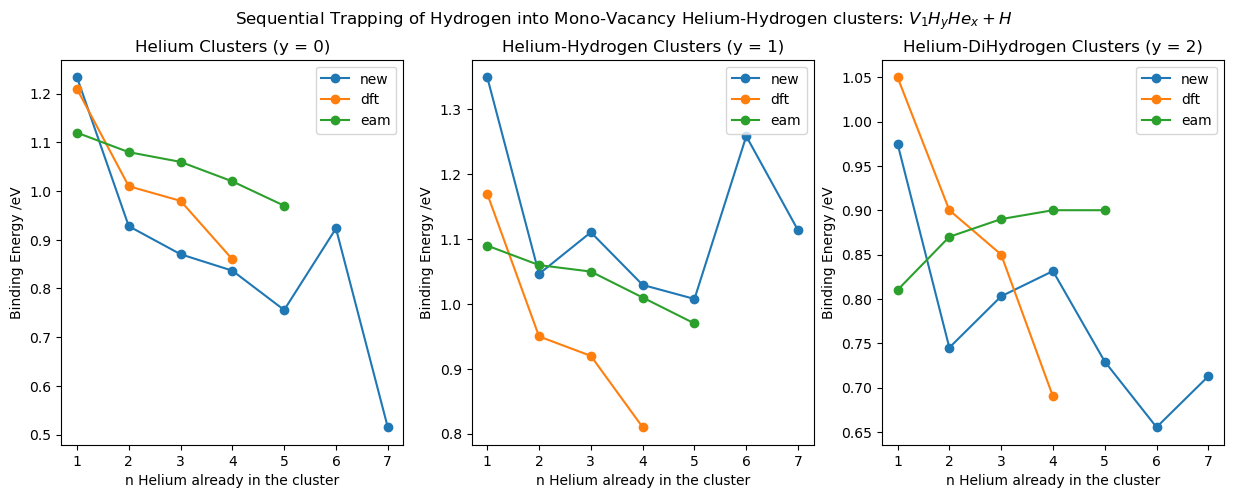

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

xlabel = 'n Helium already in the cluster'
ylabel = 'Binding Energy /eV'

### Sequential Trapping of Hydrogen into Intersitial Helium Clusters ###
eam = find_binding(df, [1,0,0], [0,1,0], [0,0,1], 'eam')
dft = find_binding(df, [1,0,0], [0,1,0], [0,0,1], 'dft')
new = find_binding(df, [1,0,0], [0,1,0], [0,0,1], 'new')

title = 'Helium Clusters (y = 0)'
axes = create_plt(axes, 0, eam, dft, new, title, xlabel, ylabel)

### Sequential Trapping of Hydrogen into a Intersitial Helium-Hydrogen Clusters ###
eam = find_binding(df, [1,1,0], [0,1,0], [0,0,1], 'eam')
dft = find_binding(df, [1,1,0], [0,1,0], [0,0,1], 'dft')
new = find_binding(df, [1,1,0], [0,1,0], [0,0,1], 'new')

title = 'Helium-Hydrogen Clusters (y = 1)'
axes = create_plt(axes, 1, eam, dft, new, title, xlabel, ylabel)


### Sequential Trapping of Hydrogen into Intersitial Helium-DiHydrogen Clusters ###
eam = find_binding(df, [1,2,0], [0,1,0], [0,0,1], 'eam')
dft = find_binding(df, [1,2,0], [0,1,0], [0,0,1], 'dft')
new = find_binding(df, [1,2,0], [0,1,0], [0,0,1], 'new')

title = 'Helium-DiHydrogen Clusters (y = 2)' 
axes = create_plt(axes, 2, eam, dft, new, title, xlabel, ylabel)

fig.suptitle(r'Sequential Trapping of Hydrogen into Mono-Vacancy Helium-Hydrogen clusters: $V_1H_yHe_x + H$')

Text(0.5, 0.98, 'Relaxation Volume of Vacancy-Helium Clusters')

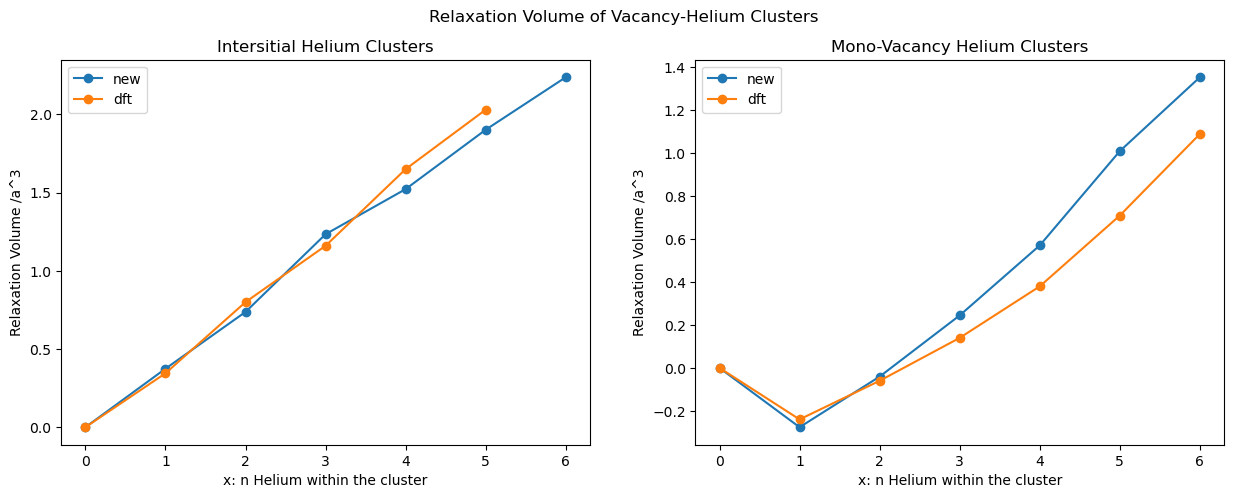

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

xlabel = 'x: n Helium within the cluster'
ylabel = 'Relaxation Volume /a^3'

new = df_to_lst(df, [0,0,1], [0,0,1], 'r_vol_new')
dft = df_to_lst(df, [0,0,1], [0,0,1], 'r_vol_dft')

new.insert(0,0)
dft.insert(0,0)

axes[0].plot(np.arange(len(new)), new, marker = 'o')
axes[0].plot(np.arange(len(dft)), dft, marker ='o')
axes[0].legend(['new', 'dft'])
axes[0].set_xlabel(xlabel)
axes[0].set_ylabel(ylabel)
axes[0].set_xticks(np.arange(len(new)))
axes[0].set_title('Intersitial Helium Clusters')

new = df_to_lst(df, [1,0,1], [0,0,1], 'r_vol_new')
dft = df_to_lst(df, [1,0,1], [0,0,1], 'r_vol_dft')

new.insert(0,0)
dft.insert(0,0)

axes[1].plot(np.arange(len(new)), new, marker = 'o')
axes[1].plot(np.arange(len(dft)), dft, marker ='o')
axes[1].legend(['new', 'dft'])
axes[1].set_xlabel(xlabel)
axes[1].set_ylabel(ylabel)
axes[1].set_xticks(np.arange(len(new)))
axes[1].set_title('Mono-Vacancy Helium Clusters')


fig.suptitle('Relaxation Volume of Vacancy-Helium Clusters')

Text(0.5, 0.98, 'Relaxation Volume of Mono-Vacancy Helium Clusters')

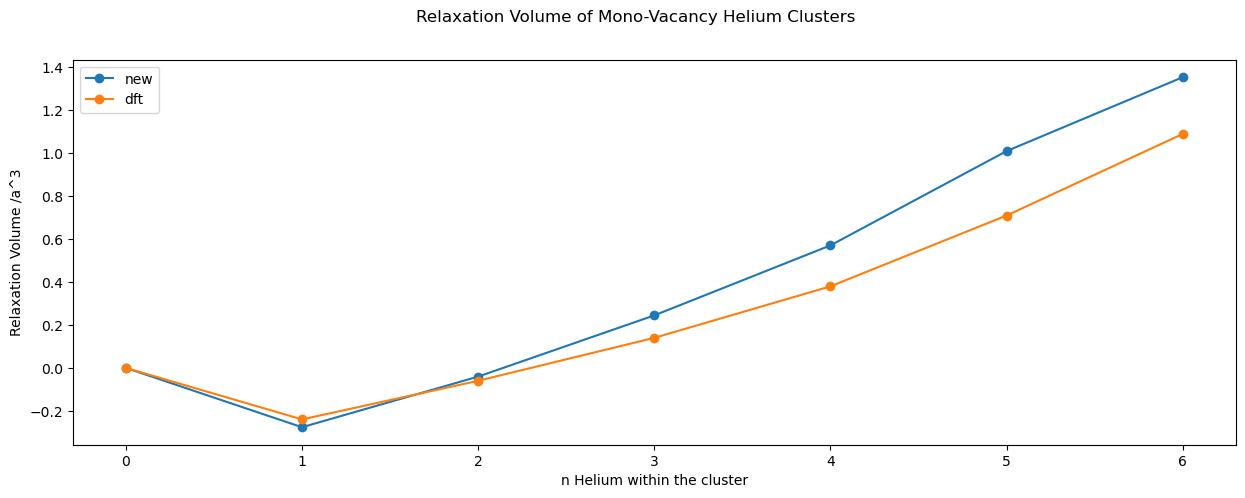

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

xlabel = 'n Helium within the cluster'
ylabel = 'Relaxation Volume /a^3'

new = df_to_lst(df, [1,0,1], [0,0,1], 'r_vol_new')
dft = df_to_lst(df, [1,0,1], [0,0,1], 'r_vol_dft')

new.insert(0,0)
dft.insert(0,0)

axes.plot(np.arange(len(new)), new, marker = 'o')
axes.plot(np.arange(len(dft)), dft, marker ='o')
axes.legend(['new', 'dft'])
axes.set_xlabel(xlabel)
axes.set_ylabel(ylabel)
axes.set_xticks(np.arange(len(new)))
fig.suptitle('Relaxation Volume of Mono-Vacancy Helium Clusters')

Text(0.5, 0.98, 'Bond Lengths of Light Elements in Bulk Tungsten')

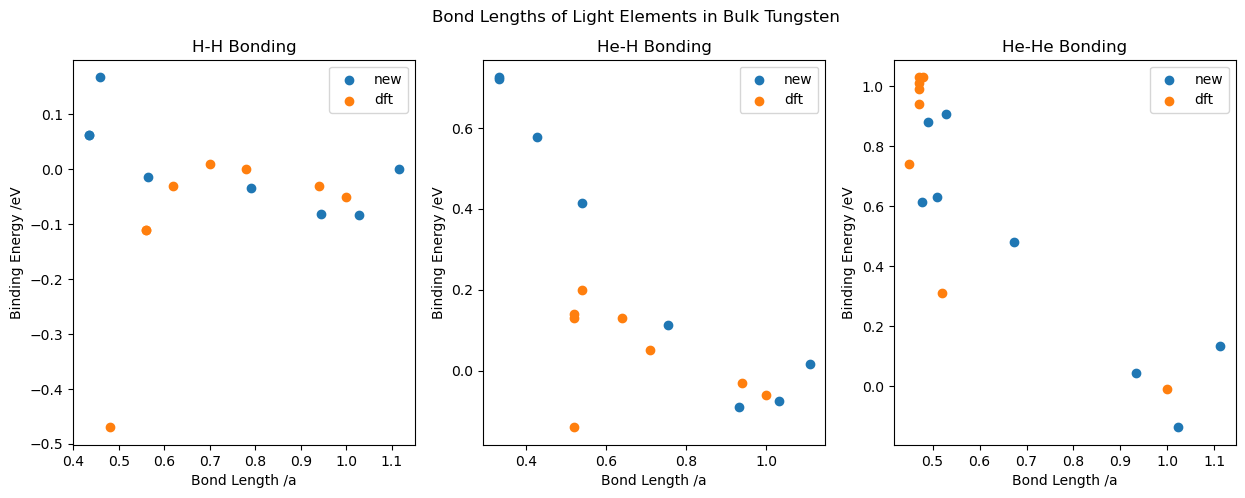

In [36]:
bonding = {}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, key in enumerate(my_bonding):

    y_new = my_bonding[key]['binding']
    y_dft = ref_bonding[key]['energy_dft']

    x_new = my_bonding[key]['b_length']
    x_dft = ref_bonding[key]['blength_dft']

    bonding[key] = {}

    bonding[key]['Bond Length (new) /a'] = x_new
    bonding[key]['Bond Length (dft) /a'] = x_dft

    bonding[key]['Binding (new) /eV'] = y_new
    bonding[key]['Binding (dft) /eV'] = y_dft

    axes[idx].scatter(x_new, y_new)
    axes[idx].scatter(x_dft, y_dft)

    axes[idx].set_xlabel('Bond Length /a')
    axes[idx].set_ylabel('Binding Energy /eV')

    axes[idx].set_title('%s Bonding' % key)

    axes[idx].legend(['new', 'dft'])

fig.suptitle('Bond Lengths of Light Elements in Bulk Tungsten')